In [2]:
# Import libraries
import pickle
import http.client, urllib.parse
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import fastai.tabular.all as fastai
np.set_printoptions(linewidth=130)
import torch
import json

load_dotenv()
key = os.getenv('API_KEY')

# longLats pickle
def load_pkl():
  longLats = pickle.load(open('./longLat.pkl', 'rb'))
  print(f"longLats loaded. {len(longLats)}")
  return longLats
def dump_pkl(longLats):
    pickle.dump(longLats, open('./longLat.pkl', 'wb'))
    print(f"pickle dumped. {len(longLats)}")
longLats = load_pkl()

# clean up data: area, date, floor, price
def load_csv():
  #return pd.read_csv('./data/Woodlands_June22_May23.csv')
  return pd.read_csv('./data/resale-flat-from-jan-2017.csv')
floor_dict = { f'0{i*3+1} TO 0{i*3+3}' if i < 3 else f'{i*3+1} TO {i*3+3}': i*3+2  for i in range(17)  }
def floor_cleanup(df):
  df['floor'] = df.storey_range.apply(lambda x:float(floor_dict[x]) if isinstance(x,str) else x)
  df.drop(['storey_range'], axis=1, inplace=True)
  return df
date_dict = { f'20{17+i}-0{j+1}' if j < 9 else f'20{17+i}-{j+1}': i*12+j  for i in range(7) for j in range(12)  }
def date_cleanup(df):
  df['date'] = df.month.apply(lambda x:float(date_dict[x]) if isinstance(x,str) else x)
  df.drop(['month'], axis=1, inplace=True)
  return df
def load_and_cleanup():
  df = load_csv()
  df = floor_cleanup(df)
  df = date_cleanup(df)
  return df

df = load_and_cleanup()
df.describe()
date_max = df.date.max()
town = 'Bukit_Panjang'
df = df[(df.town==town.replace('_', ' ').upper()) & (df.date > date_max-12)]

from pathlib import Path
file = Path(f'./data/{town}_June22_May23.csv')
df.to_csv(file,index=False)
df


longLats loaded. 7307


,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date
128077,BUKIT PANJANG,2 ROOM,488,SEGAR RD,47.0,2-room,2014,91 years 07 months,298000.0,8.0,65.0
128078,BUKIT PANJANG,2 ROOM,488,SEGAR RD,47.0,Model A,2014,91 years 07 months,265000.0,5.0,65.0
128079,BUKIT PANJANG,2 ROOM,488,SEGAR RD,47.0,Model A,2014,91 years 06 months,280000.0,11.0,65.0
128080,BUKIT PANJANG,2 ROOM,636A,SENJA RD,46.0,Model A,2015,92 years 06 months,290000.0,5.0,65.0
128081,BUKIT PANJANG,2 ROOM,636A,SENJA RD,46.0,Model A,2015,92 years 06 months,305000.0,14.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
152689,BUKIT PANJANG,EXECUTIVE,239,BT PANJANG RING RD,150.0,Maisonette,1989,64 years 10 months,750000.0,5.0,76.0
152690,BUKIT PANJANG,EXECUTIVE,147,GANGSA RD,146.0,Maisonette,1988,64 years 03 months,830000.0,5.0,76.0
152691,BUKIT PANJANG,EXECUTIVE,503,JELAPANG RD,145.0,Apartment,1998,73 years 10 months,810000.0,11.0,76.0
152692,BUKIT PANJANG,EXECUTIVE,479,SEGAR RD,125.0,Premium Apartment,2002,78 years 05 months,605000.0,5.0,76.0


In [2]:
blk_street = df.block + ' ' + df.street_name

longLats = load_pkl()
responses = []
errors = []
count = 0

conn = http.client.HTTPConnection('api.positionstack.com')
for i,add in enumerate(blk_street.unique()):
    params = urllib.parse.urlencode({
        'access_key': key,
        'query': add,
        'region': 'Singapore',
        'limit': 1,
    })
    conn.request('GET', '/v1/forward?{}'.format(params))
    res = conn.getresponse()
    data = res.read()
    dataList = json.loads(data.decode('utf-8'))['data']
    if (len(dataList)==0): 
      print(f"check {add}. No data returned")
      count += 1
      errors.append(add)
      continue
    first_response = dataList[0]
    responses.append(first_response)
    if (first_response['confidence'] > 0.9) and (first_response['country']=='Singapore'):
      longLats[f"{add}"] = (first_response['longitude'], first_response['latitude'])
      if (i%10==0): print(f"{i} of {len(blk_street.unique())}")
    else:
      print(f"check {add}. {first_response['label']}. confidence of {first_response['confidence']}")
      count += 1
      errors.append(add)

print(f"{count} errors detected")
dump_pkl(longLats)


longLats loaded. 3778
0 of 289
10 of 289
20 of 289
30 of 289
40 of 289
50 of 289
60 of 289
70 of 289
80 of 289
90 of 289
100 of 289
110 of 289
120 of 289
130 of 289
140 of 289
150 of 289
160 of 289
170 of 289
180 of 289
190 of 289
200 of 289
210 of 289
220 of 289
230 of 289
240 of 289
250 of 289
260 of 289
270 of 289
280 of 289
0 errors detected
pickle dumped. 4067


In [5]:
errors.sort()
errors

['1 JLN BT MERAH',
 '10 JLN BT HO SWEE',
 '10 JLN RUMAH TINGGI',
 '107 JLN BT MERAH',
 '108 JLN BT MERAH',
 '11 JLN BT MERAH',
 '113 JLN BT MERAH',
 '13 JLN BT MERAH',
 '131 JLN BT MERAH',
 '132 JLN BT MERAH',
 '133 JLN BT MERAH',
 '134 JLN BT MERAH',
 '135 JLN BT MERAH',
 '136 JLN BT MERAH',
 '137 JLN BT MERAH',
 '138 JLN BT MERAH',
 '139 JLN BT MERAH',
 '14 JLN BT MERAH',
 '140 JLN BT MERAH',
 '141 JLN BT MERAH',
 '142 JLN BT MERAH',
 '143 JLN BT MERAH',
 '146 JLN BT MERAH',
 '19 JLN MEMBINA',
 '2 JLN BT HO SWEE',
 '2 JLN BT MERAH',
 '20 JLN KLINIK',
 '20 JLN MEMBINA',
 '21 JLN MEMBINA',
 '22 JLN MEMBINA',
 '23 JLN MEMBINA',
 '26 JLN KLINIK',
 '28 JLN BT MERAH',
 '28 JLN KLINIK',
 '30 JLN KLINIK',
 '32 JLN BT HO SWEE',
 '34 JLN BT HO SWEE',
 '36 JLN RUMAH TINGGI',
 '37 JLN RUMAH TINGGI',
 '38 JLN RUMAH TINGGI',
 '4 JLN BT HO SWEE',
 '40 JLN RUMAH TINGGI',
 '46 JLN BT HO SWEE',
 '6 JLN BT HO SWEE',
 '7 JLN BT MERAH',
 '8 JLN RUMAH TINGGI',
 '9 JLN RUMAH TINGGI']

In [57]:
file = Path(f'./data/{town}_June22_May23_without_newest.csv')
df.to_csv(file,index=False)
df

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date
127994,BUKIT MERAH,1 ROOM,7,TELOK BLANGAH CRES,31.0,Improved,1975,51 years 10 months,248000.0,2.0,65.0
127995,BUKIT MERAH,2 ROOM,48,MOH GUAN TER,44.0,Standard,1973,49 years 07 months,432000.0,2.0,65.0
127996,BUKIT MERAH,2 ROOM,76,TELOK BLANGAH DR,44.0,Improved,1978,54 years 08 months,240000.0,8.0,65.0
127997,BUKIT MERAH,3 ROOM,119,BT MERAH VIEW,65.0,Improved,1983,59 years 08 months,325000.0,2.0,65.0
127998,BUKIT MERAH,3 ROOM,129,BT MERAH VIEW,65.0,Improved,1973,50 years 02 months,362000.0,11.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
152633,BUKIT MERAH,5 ROOM,74A,REDHILL RD,115.0,Improved,2005,81 years 07 months,898000.0,2.0,76.0
152634,BUKIT MERAH,5 ROOM,17,TELOK BLANGAH CRES,119.0,Improved,2002,77 years 09 months,850000.0,20.0,76.0
152635,BUKIT MERAH,5 ROOM,14A,TELOK BLANGAH CRES,119.0,Improved,1999,75 years 06 months,808000.0,8.0,76.0
152636,BUKIT MERAH,5 ROOM,26,TELOK BLANGAH CRES,114.0,Standard,1975,51 years 03 months,790000.0,8.0,76.0


In [3]:
def lat_long(df):
  adds = (df.block + ' ' + df.street_name)
  longLat = adds.apply(lambda x: longLats[x])
  df['long'] = longLat.apply(lambda x: x[0])
  df['lat'] = longLat.apply(lambda x: x[1])
  return df
lat_long(df)
df.describe()

,floor_area_sqm,lease_commence_date,resale_price,floor,date,long,lat
count,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000
mean,101.768166,2000.171857,539223.584775,9.785467,70.241061,103.767455,1.383215
std,20.537197,9.916009,125691.476046,6.288310,3.429026,0.004791,0.004717
min,46.000000,1986.000000,265000.000000,2.000000,65.000000,103.757213,1.371894
25%,92.000000,1989.000000,456500.000000,5.000000,67.000000,103.763655,1.379715
50%,102.000000,1999.000000,518000.000000,8.000000,70.000000,103.768475,1.384360
75%,113.000000,2005.000000,610000.000000,14.000000,73.000000,103.771270,1.386981
max,155.000000,2016.000000,965000.000000,35.000000,76.000000,103.776145,1.389933


SuggestedLRs(valley=0.0014454397605732083, slide=6.309573450380412e-07)

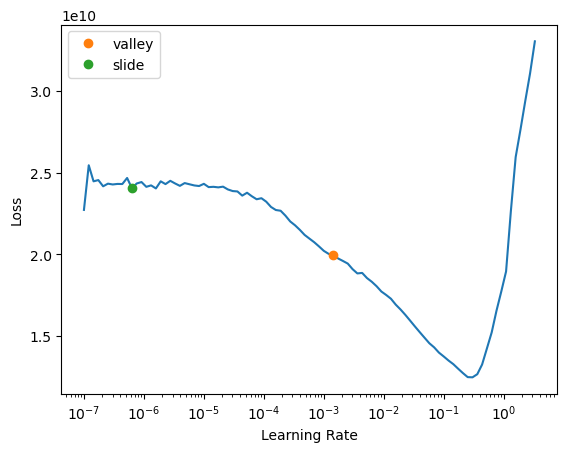

In [4]:
dls = fastai.TabularDataLoaders.from_df(df,procs=[fastai.Normalize],cont_names=["floor", "floor_area_sqm", "lease_commence_date", "date", "lat","long"],y_names=["resale_price"])
dls.show_batch()
def MSE(yhat,y):
  return torch.mean(torch.square(yhat-y))
def RMSE(yhat,y):
  return torch.sqrt(MSE(yhat,y))
learn = fastai.tabular_learner(dls,y_range=(df.resale_price.min()*0.95, df.resale_price.max()*1.05),loss_func=MSE,metrics=RMSE)
learn.lr_find(suggest_funcs=(fastai.valley,fastai.slide))


In [10]:
learn = fastai.tabular_learner(
  dls,y_range=(df.resale_price.min()*0.95, df.resale_price.max()*1.05),
  loss_func=MSE,metrics=RMSE,
  cbs=[fastai.SaveModelCallback(),fastai.EarlyStoppingCallback(patience=5)]
)
learn.fit_one_cycle(100,5e-2)
learn.validate()


Better model found at epoch 0 with valid_loss value: 31239.87890625.


(#2) [978720384.0,31239.87890625]

In [11]:
# predict prices on map
row = df.drop(['resale_price'], axis=1).iloc[0].copy()
cats = ['floor', 'floor_area_sqm', 'lease_commence_date', 'date']
for cat in cats:
  row[cat] = df[cat].median()
latMin, latMax = df.lat.min(),df.lat.max()
latLeft = latMin - (latMax-latMin)/10
latRight = latMax + (latMax-latMin)/10
longMin, longMax = df.long.min(),df.long.max()
longLeft = longMin - (longMax-longMin)/10
longRight = longMax + (longMax-longMin)/10
n1 = 5*25
n2 = 4*25
longs = np.linspace(longLeft, longRight, n1)
lats = np.linspace(latLeft, latRight, n2)
prices = np.ndarray((n2,n1))
for i,lat in enumerate(lats):
  if i%10==0: print(f"{i} of {n2}") 
  row['lat'] = lat
  for j,long in enumerate(longs):
    row['long'] = long
    with learn.no_bar(), learn.no_logging():
      _, yPred, _ = learn.predict(row)
      prices[i][j] = yPred.item()

0 of 100
10 of 100
20 of 100
30 of 100
40 of 100
50 of 100
60 of 100
70 of 100
80 of 100
90 of 100


In [10]:
import http.client, urllib.parse
import json

mrts = ["Bukit Panjang MRT"]
longLats = load_pkl()

responses = []
for mrt in mrts:
	conn = http.client.HTTPConnection('api.positionstack.com')
	params = urllib.parse.urlencode({
		'access_key': key,
		'query': mrt[:-4] + ' Station',
		'region': 'Singapore',
		'limit': 1,
	})
	conn.request('GET', '/v1/forward?{}'.format(params))
	res = conn.getresponse()
	data = res.read()
	dataList = json.loads(data.decode('utf-8'))['data']
	if (len(dataList)==0): 
		print(f"check {add}. No data returned")
		count += 1
		errors.append(add)
		continue
	first_response = dataList[0]
	responses.append(first_response)
	if (first_response['confidence'] > 0.9) and (first_response['country']=='Singapore'):
		longLats[f"{mrt}"] = (first_response['longitude'], first_response['latitude'])
		print(f"{first_response['label']}, confidence {first_response['confidence']}")
	else:
		print(f"check {mrt}. {first_response['label']}. confidence of {first_response['confidence']}")

dump_pkl(longLats)


longLats loaded. 4098
After Bukit Panjang Station, Singapore, confidence 1
pickle dumped. 4099


In [18]:
longLats['Upper Changi MRT']

(103.96138, 1.341393)

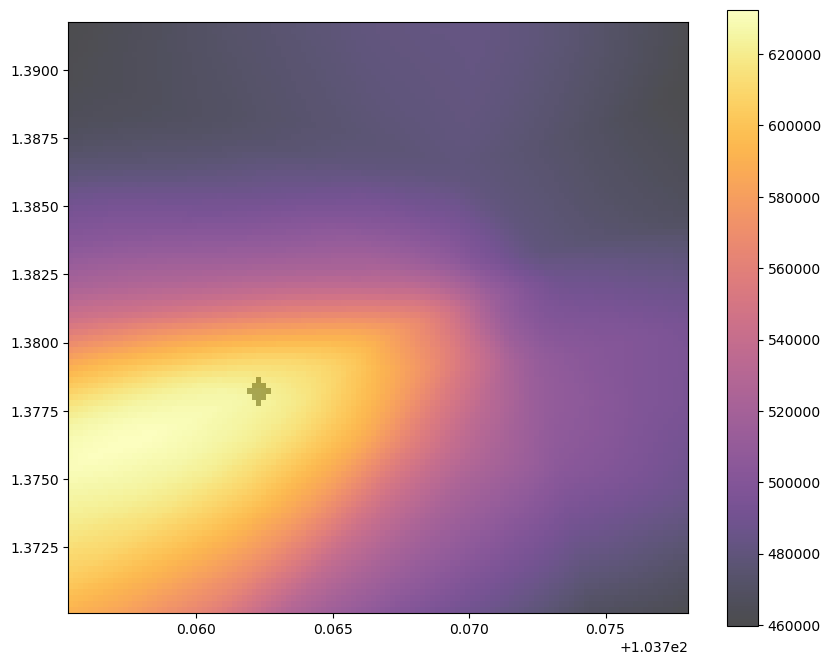

In [12]:
def min_coords(long,lat):
  return (np.abs((longs-long)).argmin(), np.abs(lats-lat).argmin())
def map_left(i,j):
  mrt_map[j-2][i+1]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j+2][i+1]=1
def map_sq(i,j):
  mrt_map[j-1][i-1]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j+1][i-1]=1
def map_right(i,j):
  mrt_map[j-2][i-1]=1
  mrt_map[j-1][i-1]=1
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i]=1
  mrt_map[j+1][i-1]=1
  mrt_map[j+2][i-1]=1
def map_up(i,j):
  mrt_map[j+1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j-1][i-2]=1
  mrt_map[j-1][i-1]=1
  mrt_map[j-1][i+2]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i]=1
def map_down(i,j):
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i-2]=1
  mrt_map[j+1][i-1]=1
  mrt_map[j+1][i+2]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j+1][i]=1
def map_star(i,j):
  mrt_map[j+1][i]=1
  mrt_map[j+1][i-1]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j-1][i]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i-1]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j][i-2]=1
  mrt_map[j][i+2]=1
  mrt_map[j+2][i]=1
  mrt_map[j-2][i]=1
mrt_map = np.zeros((n2,n1))

mrts = ["Bukit Panjang MRT"]
map_star(*min_coords(*longLats[mrts[0]]))
#map_down(*min_coords(*longLats[mrts[1]]))
#map_left(*min_coords(*longLats[mrts[2]]))
#map_right(*min_coords(*longLats[mrts[3]]))
#map_right(*min_coords(*longLats[mrts[4]]))

fig,ax=plt.subplots()
#mrt
#color map
shw2 = ax.imshow(mrt_map, extent=[longLeft, longRight, latLeft, latRight], origin='lower',cmap='Greys',alpha=1.0)
shw = ax.imshow(prices, extent=[longLeft, longRight, latLeft, latRight], origin='lower',alpha=0.7, cmap='inferno')
bar = plt.colorbar(shw)
fig.set_figwidth(10)
fig.set_figheight(10/n1*n2)

plt.show()

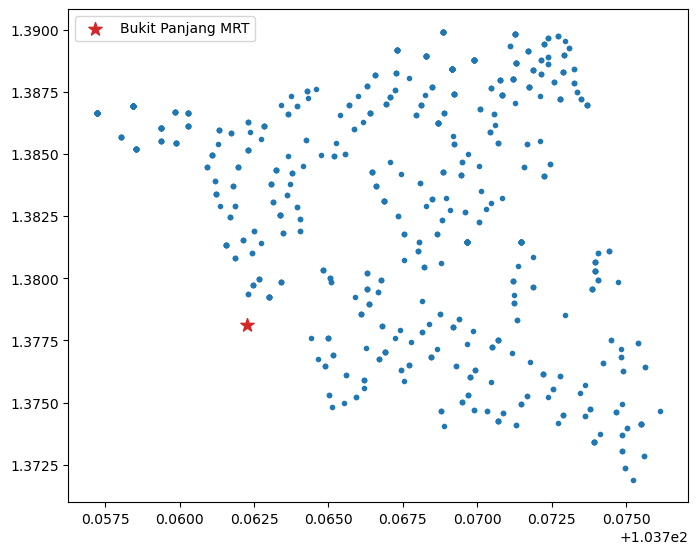

In [13]:
markers = ["*", 'v', "<", '>', '>', '^', '^']

fig,ax2=plt.subplots()
ax2.scatter(df.long,df.lat,marker='.')


for i,mrt in enumerate(mrts):
  ax2.scatter([longLats[mrt][0]], [longLats[mrt][1]],marker=markers[i],c='#d62728',label=mrt,s=100)
ax2.legend(loc='upper left')
fig.set_figwidth(8)
fig.set_figheight(8/n1*n2)

plt.show()

for mrt in mrts:
  (i,j) = min_coords(*longLats[mrt])
